In [1]:
# !unzip OA.zip

In [2]:
!pip install torchinfo early-stopping-pytorch

## Importing the relevant libraries

In [3]:
import torch, warnings, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchinfo import summary
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from early_stopping_pytorch import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from PIL import Image

In [4]:
# Checking for GPU device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


## Defining image transformations

In [5]:
train_img_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.Resize(size=(128,128)),
    transforms.CenterCrop(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_img_transforms

Compose(
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomAdjustSharpness(sharpness_factor=2,p=0.5)
    RandomAutocontrast(p=0.5)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
test_img_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.CenterCrop(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_img_transforms

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Loading the train and test datasets

In [7]:
train_dir = "/kaggle/input/oral-disease-classification/TRAIN"
test_dir = "/kaggle/input/oral-disease-classification/TEST"

train_df = datasets.ImageFolder(root=train_dir,transform=train_img_transforms)
test_df = datasets.ImageFolder(root=test_dir,transform=test_img_transforms)

In [8]:
len(train_df), len(test_df)

(1486, 408)

## Creating Data Loaders for train and test sets

In [9]:
train_data_loader = DataLoader(dataset=train_df,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device='cuda')
test_data_loader = DataLoader(dataset=test_df,batch_size=32,shuffle=False,pin_memory=True,pin_memory_device='cuda')

## Visualizing a sample of the train data loader

In [10]:
for images, labels in train_data_loader:
  break

In [11]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

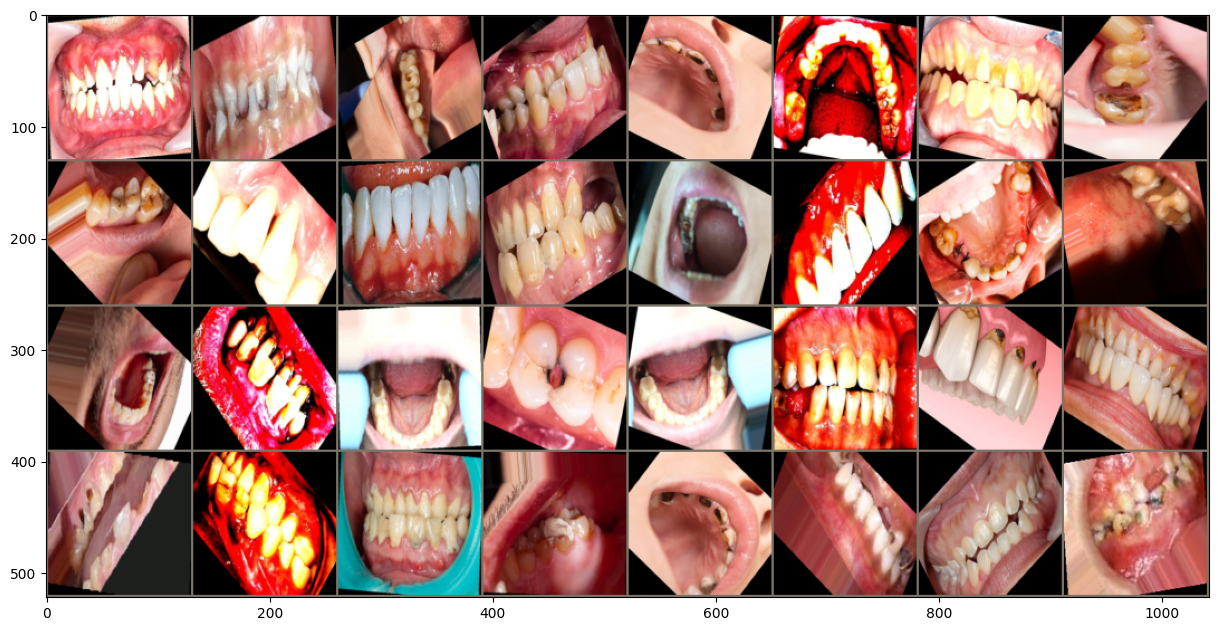

In [12]:
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])
inv_normalized_img_grid = inv_normalize(img_grid)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(inv_normalized_img_grid,(1,2,0)))
plt.show();

## Defining the CNN model architecture

In [13]:
((16+2*1-3)/1 + 1)/2

8.0

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # 64,64,32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 32,32,64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # 16,16,128
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # 8,8,256
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = X.view(-1,8*8*256)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.1)
        X = F.relu(self.fc3(X))
        return self.fc4(X)  # Raw output for use with BCEWithLogitsLoss

In [15]:
torch.manual_seed(42)
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            18,496
├─BatchNorm2d: 1-4                       128
├─Conv2d: 1-5                            73,856
├─BatchNorm2d: 1-6                       256
├─Conv2d: 1-7                            295,168
├─BatchNorm2d: 1-8                       512
├─Linear: 1-9                            4,194,560
├─Linear: 1-10                           32,896
├─Linear: 1-11                           8,256
├─Linear: 1-12                           65
Total params: 4,625,153
Trainable params: 4,625,153
Non-trainable params: 0

In [17]:
total_params = 0

for param in model.parameters():
  print(param.numel())
  total_params += param.numel()

print(f"Total Parameters: {total_params}")

864
32
32
32
18432
64
64
64
73728
128
128
128
294912
256
256
256
4194304
256
32768
128
8192
64
64
1
Total Parameters: 4625153


## Training the CNN model

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model.parameters(),lr=1e-3,weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=20,gamma=0.1)
early_stopping = EarlyStopping(patience=60,verbose=True) # High patience is due to a lot of random noise in test loss

In [19]:
epochs = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()

for i in range(1,epochs+1):
  train_correct = 0
  test_correct = 0

  model.train()

  for _, (X_train, y_train) in enumerate(train_data_loader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(X_train).flatten()
    
    # Compute loss (convert to float for binary cross-entropy)
    loss = criterion(y_pred, y_train.float())
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    predicted = (torch.sigmoid(y_pred) >= 0.5).int()
    train_correct += (predicted == y_train.int()).sum()

  scheduler.step()
  train_losses.append(loss.item())
  train_accuracies.append(train_correct.item()/len(train_data_loader.dataset))

  model.eval()

  with torch.no_grad():

    for _, (X_test, y_test) in enumerate(test_data_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_pred = model(X_test).flatten()
      predicted = (torch.sigmoid(y_pred) >= 0.5).int()
      test_correct += (predicted == y_test.int()).sum()

  test_loss = criterion(y_pred,y_test.float())
  test_losses.append(test_loss.item())
  test_accuracies.append(test_correct.item()/len(test_data_loader.dataset))

  print(f"Epoch {i} -> Train Loss: {loss.item()} | Test Loss: {test_loss.item()} | Train Accuracy: {train_correct.item()/len(train_data_loader.dataset)} | Test Accuracy: {test_correct.item()/len(test_data_loader.dataset)}")

  early_stopping(test_loss.item(),model)

  if early_stopping.early_stop:
    print(f"Early stopping at epoch {i}")
    break

print(f"Time taken in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Train Loss: 0.060644641518592834 | Test Loss: 0.3151496648788452 | Train Accuracy: 0.8310901749663526 | Test Accuracy: 0.9142156862745098
Validation loss decreased (inf --> 0.315150).  Saving model ...
Epoch 2 -> Train Loss: 1.20784330368042 | Test Loss: 0.5764461755752563 | Train Accuracy: 0.8654104979811574 | Test Accuracy: 0.8578431372549019
EarlyStopping counter: 1 out of 60
Epoch 3 -> Train Loss: 0.47543126344680786 | Test Loss: 0.3095831871032715 | Train Accuracy: 0.8600269179004038 | Test Accuracy: 0.9215686274509803
Validation loss decreased (0.315150 --> 0.309583).  Saving model ...
Epoch 4 -> Train Loss: 0.29805880784988403 | Test Loss: 0.3548920750617981 | Train Accuracy: 0.8977119784656796 | Test Accuracy: 0.8995098039215687
EarlyStopping counter: 1 out of 60
Epoch 5 -> Train Loss: 0.18839167058467865 | Test Loss: 0.2554595470428467 | Train Accuracy: 0.9010767160161507 | Test Accuracy: 0.9068627450980392
Validation loss decreased (0.309583 --> 0.255460).  Saving 

## Visualizing model performance on training and evaluation sets

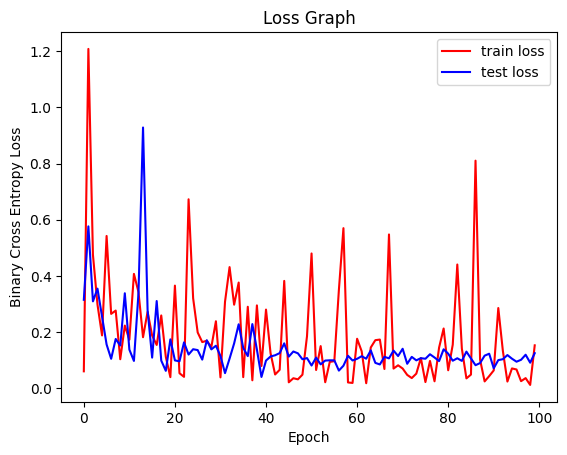

In [20]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

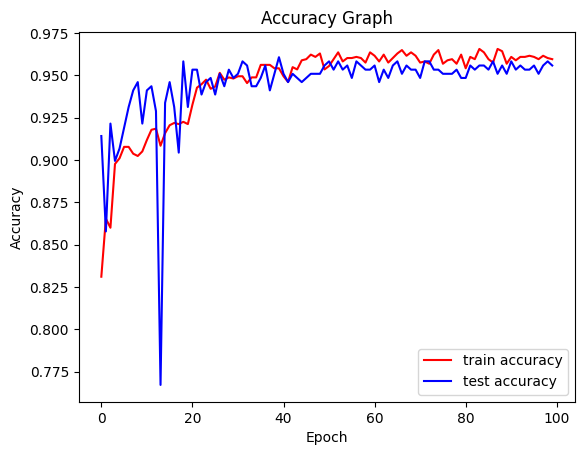

In [21]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

## Model Evaluation

In [22]:
test_correct = 0
predictions = []
actual_values = []

with torch.no_grad():
    for X_test, y_test in test_data_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test).flatten()
        predicted = (torch.sigmoid(y_pred) >= 0.5).int()
        predictions.append(predicted)
        actual_values.append(y_test.int())
        test_correct += (predicted == y_test.int()).sum().item()

print("Mean test accuracy:", test_correct/len(test_data_loader.dataset))

Mean test accuracy: 0.9534313725490197


In [23]:
actual_labels = np.concatenate([label.cpu().numpy() for label in actual_values])
predicted_labels = np.concatenate([pred.cpu().numpy() for pred in predictions])

Confusion Matrix:
[[201   3]
 [ 16 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95       204
           1       0.98      0.92      0.95       204

    accuracy                           0.95       408
   macro avg       0.96      0.95      0.95       408
weighted avg       0.96      0.95      0.95       408



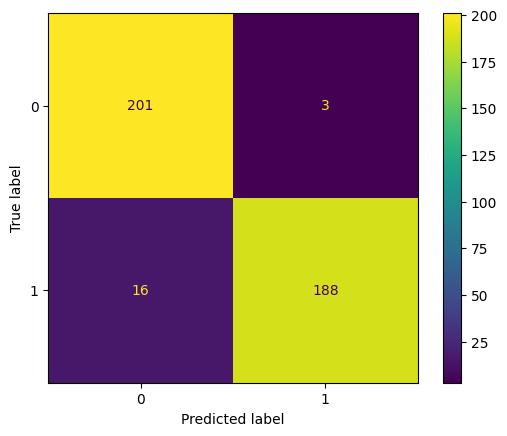

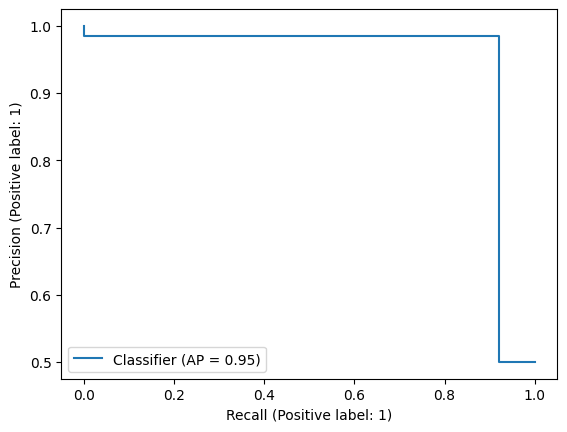

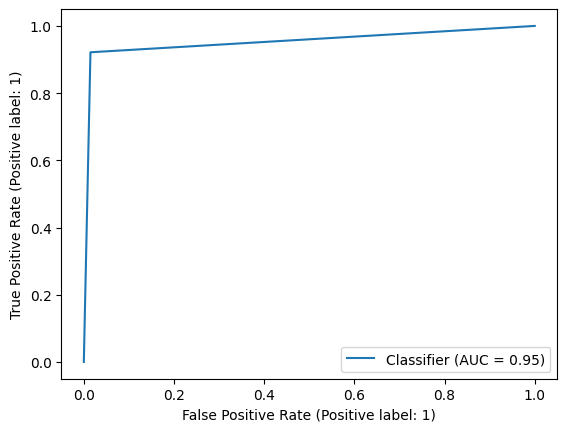

In [24]:
print("Confusion Matrix:")
print(confusion_matrix(actual_labels,predicted_labels))
print("Classification Report:")
print(classification_report(actual_labels,predicted_labels))
ConfusionMatrixDisplay.from_predictions(actual_labels,predicted_labels)
plt.show()
PrecisionRecallDisplay.from_predictions(actual_labels,predicted_labels)
plt.show()
RocCurveDisplay.from_predictions(actual_labels,predicted_labels)
plt.show();

The CNN model achieves a remarkable 96% accuracy on the test set, which is commendable considering its simplified architecture. 

## Saving the model for deployment

In [25]:
torch.save(model,'oral_disease_classifier.pt')

## Model Inference

In [26]:
def generate_predictions(model,image_path):
    image = Image.open(image_path).convert("RGB")
    transformed_img = train_img_transforms(image).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        pred = model(transformed_img).item()

    if int(pred >= 0.5) == 1:
        return "Gingivitis"
        
    return "Caries"

In [27]:
generate_predictions(model,"/kaggle/input/oral-disease-classification/TEST/Gingivitis/157_1.jpg")

'Gingivitis'

In [28]:
generate_predictions(model,"/kaggle/input/oral-disease-classification/TEST/Caries/202_2.jpg")

'Caries'